In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS

from textblob import TextBlob

from tqdm import tqdm_notebook as tqdm
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

C:\Users\HP\Anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\Users\HP\Anaconda3\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict


In [2]:
df1 = pd.read_csv('ethiopia_tripadvisor_data_model_3.csv')
df1.head()

,Destination Name,Destination Type,Review Head,Review Body,Review Text,RB_Sentence1,TextBlob Polarity Head,TextBlob Polarity Body,TextBlob Polarity Text,TextBlob Polarity RBS1,RB_Sentence1_Split
0,Rock-Hewn Churches of Lalibela,Landmarks,Incredible locations don't be put off thinking...,Amazing location must visit. This site is mark...,Incredible locations don't be put off thinking...,Amazing location must visit.,-0.05,0.300000,0.125000,0.6000,"['Amazing', 'location', 'must', 'visit.']"
1,Rock-Hewn Churches of Lalibela,Landmarks,It is a real miracle of the world!,I do recommend to visit Lalibela churches and ...,It is a real miracle of the world! I do recomm...,I do recommend to visit Lalibela churches and ...,0.25,-0.150000,-0.016667,0.0000,"['I', 'do', 'recommend', 'to', 'visit', 'Lalib..."
2,Rock-Hewn Churches of Lalibela,Landmarks,Incredible experience,A must visit in Ethiopia - one of the most uni...,Incredible experience A must visit in Ethiopia...,A must visit in Ethiopia - one of the most uni...,0.90,0.345000,0.483750,0.4375,"['A', 'must', 'visit', 'in', 'Ethiopia', '-', ..."
3,Rock-Hewn Churches of Lalibela,Landmarks,Amazing,These churches have to be seen to be believed....,Amazing These churches have to be seen to be b...,These churches have to be seen to be believed.,0.60,0.225000,0.350000,0.0000,"['These', 'churches', 'have', 'to', 'be', 'see..."
4,Rock-Hewn Churches of Lalibela,Landmarks,So much history,Thanks to our tour organiser Ephram who is bas...,So much history Thanks to our tour organiser E...,Thanks to our tour organiser Ephram who is bas...,0.20,0.233333,0.228571,0.2000,"['Thanks', 'to', 'our', 'tour', 'organiser', '..."


In [3]:
df1['RH_Split'] = df1['Review Head'].apply(lambda x: x.split(' '))
df1['RB_Split'] = df1['Review Body'].apply(lambda x: x.split(' '))
df1['RT_Split'] = df1['Review Text'].apply(lambda x: x.split(' '))
df1['RB_Sentence1_Split'] = df1['RB_Sentence1'].apply(lambda x: x.split(' '))
df1.head()

,Destination Name,Destination Type,Review Head,Review Body,Review Text,RB_Sentence1,TextBlob Polarity Head,TextBlob Polarity Body,TextBlob Polarity Text,TextBlob Polarity RBS1,RB_Sentence1_Split,RH_Split,RB_Split,RT_Split
0,Rock-Hewn Churches of Lalibela,Landmarks,Incredible locations don't be put off thinking...,Amazing location must visit. This site is mark...,Incredible locations don't be put off thinking...,Amazing location must visit.,-0.05,0.300000,0.125000,0.6000,"[Amazing, location, must, visit.]","[Incredible, locations, don't, be, put, off, t...","[Amazing, location, must, visit., This, site, ...","[Incredible, locations, don't, be, put, off, t..."
1,Rock-Hewn Churches of Lalibela,Landmarks,It is a real miracle of the world!,I do recommend to visit Lalibela churches and ...,It is a real miracle of the world! I do recomm...,I do recommend to visit Lalibela churches and ...,0.25,-0.150000,-0.016667,0.0000,"[I, do, recommend, to, visit, Lalibela, church...","[It, is, a, real, miracle, of, the, world!]","[I, do, recommend, to, visit, Lalibela, church...","[It, is, a, real, miracle, of, the, world!, I,..."
2,Rock-Hewn Churches of Lalibela,Landmarks,Incredible experience,A must visit in Ethiopia - one of the most uni...,Incredible experience A must visit in Ethiopia...,A must visit in Ethiopia - one of the most uni...,0.90,0.345000,0.483750,0.4375,"[A, must, visit, in, Ethiopia, -, one, of, the...","[Incredible, experience, ]","[A, must, visit, in, Ethiopia, -, one, of, the...","[Incredible, experience, A, must, visit, in, E..."
3,Rock-Hewn Churches of Lalibela,Landmarks,Amazing,These churches have to be seen to be believed....,Amazing These churches have to be seen to be b...,These churches have to be seen to be believed.,0.60,0.225000,0.350000,0.0000,"[These, churches, have, to, be, seen, to, be, ...",[Amazing],"[These, churches, have, to, be, seen, to, be, ...","[Amazing, These, churches, have, to, be, seen,..."
4,Rock-Hewn Churches of Lalibela,Landmarks,So much history,Thanks to our tour organiser Ephram who is bas...,So much history Thanks to our tour organiser E...,Thanks to our tour organiser Ephram who is bas...,0.20,0.233333,0.228571,0.2000,"[Thanks, to, our, tour, organiser, Ephram, who...","[So, much, history]","[Thanks, to, our, tour, organiser, Ephram, who...","[So, much, history, Thanks, to, our, tour, org..."


In [4]:
df1['Destination Type'].value_counts()

Landmarks       3803
Museums         2507
Nature/Parks    2001
Name: Destination Type, dtype: int64

### Topic Modelling

In [5]:
# NLTK Stop words
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

test_subset = df1['RB_Sentence1_Split'].values
sid = SentimentIntensityAnalyzer()
pos_word_list=[]
neu_word_list=[]
neg_word_list=[]

for value in test_subset:
    for word in value:
        if (sid.polarity_scores(word)['compound']) >= 0.4:
            pos_word_list.append(word)
        elif (sid.polarity_scores(word)['compound']) <= -0.4:
            print
            neg_word_list.append(word)
        else:
            neu_word_list.append(word)                

print('Positive :', len(pos_word_list))       
print('Neutral :', len(neu_word_list))    
print('Negative :', len(neg_word_list))

Positive : 5775
Neutral : 133685
Negative : 748


In [6]:
from nltk.corpus import stopwords

main_stop_words = ['ethiopia', 'ethiopian', 'rock', 'hewn', 'church', 'churches', 'park', 'parks', 'museum', 
                       'museums', 'omo', 'valley', 'mountain', 'mountains', 'addis', 'ababa', 'lucy', 'simien', 
                       'national', 'lalibela', 'gelada', 'haile', 'selassie', 'gondar', 'africa' , 'harar', 
                       'cathedral', 'cathedrals', 'place', 'visit', 'girmay', 
                       '\n', '‘s']
positive_stop_words = list(set(pos_word_list))
negative_stop_words = list(set(neg_word_list))
total_stop_words = main_stop_words + positive_stop_words + negative_stop_words

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
stop_words.extend(total_stop_words)
print('Stop Words: ', len(stop_words))

Stop Words:  1148


In [7]:
# Convert to list
data = df1[df1['Destination Type'] == 'Landmarks'][df1['TextBlob Polarity RBS1'] < 0]['RB_Sentence1'].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['Dont miss these sites, even though a couple now have UNESCO coverings on '
 'them, which does decrease from the mystery a little.']


In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['dont', 'miss', 'these', 'sites', 'even', 'though', 'couple', 'now', 'have', 'unesco', 'coverings', 'on', 'them', 'which', 'does', 'decrease', 'from', 'the', 'mystery', 'little']]


In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['dont', 'miss', 'these', 'sites', 'even', 'though', 'couple', 'now', 'have', 'unesco', 'coverings', 'on', 'them', 'which', 'does', 'decrease', 'from', 'the', 'mystery', 'little']


In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['miss', 'site', 'even', 'couple', 'covering', 'decrease', 'mystery', 'little']]


In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]]


In [13]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('couple', 1),
  ('covering', 1),
  ('decrease', 1),
  ('even', 1),
  ('little', 1),
  ('miss', 1),
  ('mystery', 1),
  ('site', 1)]]

In [14]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [15]:
# Print the Keyword in the n topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.040*"seem" + 0.025*"road" + 0.022*"lot" + 0.019*"building" + 0.019*"way" '
  '+ 0.018*"town" + 0.017*"rest" + 0.017*"tomb" + 0.017*"week" + '
  '0.016*"whole"'),
 (1,
  '0.064*"walk" + 0.032*"away" + 0.030*"minute" + 0.028*"admission" + '
  '0.027*"different" + 0.024*"charge" + 0.020*"reason" + 0.020*"ground" + '
  '0.019*"indeed" + 0.016*"bite"'),
 (2,
  '0.068*"see" + 0.057*"site" + 0.032*"take" + 0.031*"go" + 0.031*"get" + '
  '0.030*"way" + 0.025*"thing" + 0.023*"complex" + 0.021*"usually" + '
  '0.016*"time"'),
 (3,
  '0.039*"time" + 0.033*"hour" + 0.032*"trip" + 0.031*"long" + 0.028*"large" + '
  '0.027*"small" + 0.026*"build" + 0.024*"stone" + 0.024*"go" + 0.018*"drive"'),
 (4,
  '0.039*"city" + 0.026*"old" + 0.023*"enter" + 0.023*"experience" + '
  '0.022*"offer" + 0.020*"hard" + 0.019*"learn" + 0.017*"travel" + '
  '0.017*"aksum" + 0.017*"expensive"'),
 (5,
  '0.070*"day" + 0.070*"find" + 0.050*"orthodox" + 0.045*"part" + 0.036*"tour" '
  '+ 0.035*"spend" + 0.034*"mu

In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.3144738071760855

Coherence Score:  0.5640882013092519


In [17]:
# Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
# vis

In [18]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
import os
os.environ.update({'MALLET_HOME':r'C:/Users/HP/mallet-2.0.8/'})
mallet_path = r'C:\Users\HP\mallet-2.0.8\bin\mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [19]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('time', 0.1276595744680851),
   ('build', 0.0851063829787234),
   ('late', 0.047872340425531915),
   ('town', 0.031914893617021274),
   ('thing', 0.026595744680851064),
   ('half', 0.026595744680851064),
   ('round', 0.02127659574468085),
   ('month', 0.02127659574468085),
   ('cave', 0.02127659574468085),
   ('center', 0.015957446808510637)]),
 (1,
  [('city', 0.05921052631578947),
   ('single', 0.039473684210526314),
   ('closed', 0.039473684210526314),
   ('tomb', 0.039473684210526314),
   ('holy_trinity', 0.039473684210526314),
   ('large', 0.039473684210526314),
   ('ancient', 0.03289473684210526),
   ('buy', 0.03289473684210526),
   ('sermon', 0.02631578947368421),
   ('monastery', 0.019736842105263157)]),
 (2,
  [('trip', 0.10497237569060773),
   ('orthodox', 0.0718232044198895),
   ('long', 0.06077348066298342),
   ('carve', 0.04419889502762431),
   ('worth', 0.04419889502762431),
   ('pay', 0.04419889502762431),
   ('close', 0.03867403314917127),
   ('historic', 0.033

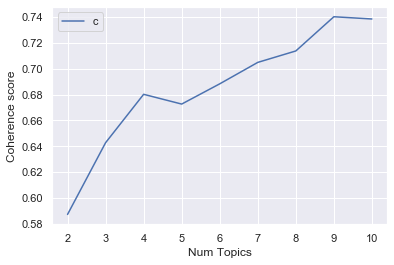

In [20]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

start1 = 2 
limit1 = 11
step1 = 1

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start1, limit=limit1, step=step1)

x = range(start1, limit1, step1)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [21]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5873
Num Topics = 3  has Coherence Value of 0.6428
Num Topics = 4  has Coherence Value of 0.6802
Num Topics = 5  has Coherence Value of 0.6727
Num Topics = 6  has Coherence Value of 0.6883
Num Topics = 7  has Coherence Value of 0.7049
Num Topics = 8  has Coherence Value of 0.7137
Num Topics = 9  has Coherence Value of 0.7402
Num Topics = 10  has Coherence Value of 0.7385


In [20]:
# optimal_model = model_list[7] # Number of Topics = 9

optimal_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=9, id2word=id2word)
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.110*"site" + 0.079*"tour" + 0.073*"part" + 0.042*"carve" + 0.042*"stone" '
  '+ 0.031*"monastery" + 0.026*"cost" + 0.026*"big" + 0.021*"fee" + '
  '0.021*"expensive"'),
 (1,
  '0.095*"guide" + 0.052*"hour" + 0.043*"visitor" + 0.033*"thing" + '
  '0.029*"close" + 0.024*"world" + 0.024*"building" + 0.019*"make" + '
  '0.019*"ground" + 0.019*"emperor"'),
 (2,
  '0.075*"visit" + 0.048*"pay" + 0.048*"travel" + 0.048*"arrive" + '
  '0.032*"live" + 0.027*"hard" + 0.027*"religious" + 0.022*"admission" + '
  '0.022*"expectation" + 0.022*"sermon"'),
 (3,
  '0.087*"walk" + 0.087*"find" + 0.051*"visit" + 0.046*"drive" + 0.036*"road" '
  '+ 0.031*"large" + 0.031*"closed" + 0.031*"reason" + 0.026*"wall" + '
  '0.021*"month"'),
 (4,
  '0.096*"trip" + 0.066*"complex" + 0.056*"long" + 0.051*"city" + 0.051*"year" '
  '+ 0.045*"enter" + 0.040*"ago" + 0.020*"century" + 0.020*"highlight" + '
  '0.020*"rest"'),
 (5,
  '0.200*"day" + 0.079*"spend" + 0.053*"expensive" + 0.047*"locate" + '
  '0.047*"

In [21]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.1429,"day, spend, expensive, locate, ticket, village...","Dont miss these sites, even though a couple no..."
1,1,7.0,0.1258,"orthodox, build, local, town, holy_trinity, of...",Guide showed us round the northern churches.
2,2,4.0,0.1310,"trip, complex, long, city, year, enter, ago, c...",During Genna (Ehtiopian Christmas) youre surel...
3,3,7.0,0.1342,"orthodox, build, local, town, holy_trinity, of...",The churches are not cute by European standard...
4,4,2.0,0.1258,"visit, pay, travel, arrive, live, hard, religi...",My expectations of rock hewn churches were lai...
5,5,0.0,0.1498,"site, tour, part, carve, stone, monastery, cos...","Go there, it is unique, but choose your travel..."
6,6,0.0,0.1228,"site, tour, part, carve, stone, monastery, cos...",I thought the term “living rock” was ridiculou...
7,7,5.0,0.1426,"day, spend, expensive, locate, ticket, village...",Weve just spent 2 days visiting the churches.
8,8,5.0,0.1601,"day, spend, expensive, locate, ticket, village...",it s true it s so expensive but it s worth it ...
9,9,0.0,0.1399,"site, tour, part, carve, stone, monastery, cos...",There are 11 churches carved from single piece...


In [22]:
df_dominant_topic['Dominant_Topic'].value_counts()

0.0    63
4.0    45
6.0    41
8.0    39
5.0    39
3.0    34
1.0    34
2.0    34
7.0    31
Name: Dominant_Topic, dtype: int64

In [36]:
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 0]['Text'].values # Expensive Fees - 63
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 1]['Text'].values # Tour Guide - 34
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 2]['Text'].values # General Destination Criticism - 34
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 3]['Text'].values # Transportation Issues(too far/long time) - 34
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 4]['Text'].values # General Destination Criticism - 45
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 5]['Text'].values # Expensive Fees - 39
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 6]['Text'].values # Unavailability/ Lack of Service - 41
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 7]['Text'].values # General Destination Criticism - 31
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 8]['Text'].values # General Destination Criticism - 39

In [32]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1875,"site, tour, part, carve, stone, monastery, cos...",Our tour group got to the monastery by riding ...
1,1.0,0.1567,"guide, hour, visitor, thing, close, world, bui...",We had a morning tour with Hailu and then rand...
2,2.0,0.1648,"visit, pay, travel, arrive, live, hard, religi...",The inscription written on the stone is done i...
3,3.0,0.1637,"walk, find, visit, drive, road, large, closed,...","On the day I visited, after over an hours run ..."
4,4.0,0.1778,"trip, complex, long, city, year, enter, ago, c...",The moment you draw your eyes on this church w...
5,5.0,0.1639,"day, spend, expensive, locate, ticket, village...",The price is $50 per person which is exorbitan...
6,6.0,0.1508,"time, small, late, start, tourist, tomb, worth...",Sunday is not a great day to visit - hundreds ...
7,7.0,0.1737,"orthodox, build, local, town, holy_trinity, of...",This Cathedral is the official seat of the Ort...
8,8.0,0.1628,"entrance, experience, bit, cave, give, histori...",A longish drive and a short hike to one to the...


In [33]:
sent_topics_sorteddf_mallet['Text'].values

array(['Our tour group got to the monastery by riding mules part of the way and hiking the rest of it, which took about 5 hours round trip with a stop for coffee (from a woman in the village below Ahetan Maryam).',
       'We had a morning tour with Hailu and then randomly met Alem in the afternoon since Hailu was tied up with other matters.',
       'The inscription written on the stone is done in several languages, thus providing a key to interpretting languages previously indecipherable.',
       'On the day I visited, after over an hours run by road we found the church closed to visitors.',
       'The moment you draw your eyes on this church with its unmistakable cross atop you are mesmerized .And when you start walking in ..it just sucks you in ..takes you back few centuries .',
       'The price is $50 per person which is exorbitant- the ticket covers 5 days and maybe if you are there for that amount of time and visit every day it might make it hurt a bit less.',
       'Sunday 

In [27]:
# # Number of Documents for Each Topic
# topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# # Percentage of Documents for Each Topic
# topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# # Topic Number and Keywords
# topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# # Concatenate Column wise
# df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# # Change Column names
# df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# # Show
# df_dominant_topics